In [1]:
import tensorflow as tf
import numpy as np
import DNA_reader as reader
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
class SmallConfig(object):
    """Small Configuration"""
    learning_rate = 1.0
    max_grad_norm = 5
    num_layers = 2
    num_steps_encoder = 10
    num_steps_decoder = 15
    batch_size = 10
    hidden_size = 200
    max_epochs = 2
    max_max_epochs = 4
    lr_decay = 0.5
    init_scale = 0.1
    vocab_size = 8 # 3 extra tokens PAD,GO and EOS and 0 is unused
    compression_dims = 2

def get_config(flag='small'):
    if flag=='small':
        return SmallConfig()

# Input and Model classes

In [3]:
def data_type():
    return tf.float32

class DNA_input(object):
    def __init__(self, config, data, name=None):
        self.batch_size = batch_size = config.batch_size
        self.num_steps_encoder = num_steps_encoder = config.num_steps_encoder
        self.num_steps_decoder = num_steps_decoder = config.num_steps_decoder
        self.epoch_size = len(data[0])//batch_size
        (self.encoder_input, self.decoder_input,
        self.decoder_targets, self.labels) = reader.DNA_producer(data, config, name)

class DNA_seq_model(object):
    def __init__(self, is_training, config, input_):
        self._input = input_
        batch_size = input_.batch_size
        num_steps_encoder = input_.num_steps_encoder
        num_steps_decoder = input_.num_steps_decoder
        num_layers = config.num_layers
        size = config.hidden_size
        vocab_size = config.vocab_size
        
        lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(size, forget_bias=0.0, state_is_tuple=True)
        cell = tf.nn.rnn_cell.MultiRNNCell([lstm_cell] * num_layers, state_is_tuple=True)
        self._initial_state = cell.zero_state(batch_size, data_type())
        
        softmax_w = tf.get_variable("softmax_w", [size, vocab_size], dtype=data_type())
        softmax_b = tf.get_variable("softmax_b", [vocab_size], dtype=data_type())

        with tf.device("/cpu:0"):
            embedding = tf.get_variable(
                    "embedding", [vocab_size, size], dtype=data_type())
            encoder_inputs = tf.nn.embedding_lookup(embedding, input_.encoder_input)
            decoder_inputs = tf.nn.embedding_lookup(embedding, input_.decoder_input)
        
        def loop(prev, _):
            prev = tf.matmul(prev, softmax_w) + softmax_b
            prev_symbol = tf.stop_gradient(tf.argmax(prev, 1))
            return tf.nn.embedding_lookup(embedding, prev_symbol)
 
        compression_dims = config.compression_dims
        encoder_outputs =[]
        state = self._initial_state
        with tf.variable_scope("RNN_encoder"):
            for time_step in range(num_steps_encoder):
                if time_step > 0: tf.get_variable_scope().reuse_variables()
                (cell_output, state) = cell(encoder_inputs[:, time_step, :], state)
                encoder_outputs.append(cell_output)
#         with tf.variable_scope("state_transform"):
        W_compress = tf.get_variable("W_compress", [2*num_layers*size, compression_dims], dtype=data_type())
        b_compress = tf.get_variable("bcompress", [compression_dims], dtype=data_type())
        W_expand = tf.get_variable("W_expand", [compression_dims,2*num_layers*size], dtype=data_type())
        b_expand = tf.get_variable("b_expand", [2*num_layers*size], dtype=data_type())
        
        self._encoded_state = state
        self.compressed_state = tf.reshape(tf.transpose(tf.pack(state),[0,1,3,2]),[-1,batch_size])
        self.compressed_state = tf.transpose(self.compressed_state,[1,0])
        
        self._hidden_state = hidden_state = tf.matmul(self.compressed_state, W_compress) + b_compress
        expanded_state = tf.matmul(hidden_state, W_expand) + b_expand
        expanded_state = tf.reshape(tf.transpose(expanded_state,[1,0]),[num_layers,2,size,-1])
        expanded_state = tf.transpose(expanded_state,[0,1,3,2])
        expanded_state = tf.unpack(expanded_state, axis=0)
        state_list = []
        for i,layer in enumerate(expanded_state):
            state_list.append(tuple(tf.unpack(layer, axis=0)))
        
        self.recovered_state = tuple(state_list)

        expanded_state= self.recovered_state
        
        decoder_inputs_list = tf.unpack(decoder_inputs, axis=1)
        (decoder_outputs, state) = tf.nn.seq2seq.rnn_decoder(decoder_inputs_list, expanded_state, cell, 
                                                             loop_function=loop if not(is_training) else None)
        decoder_output = tf.reshape(tf.concat(1, decoder_outputs), [-1, size])

        logits = tf.matmul(decoder_output, softmax_w) + softmax_b
        self._probabilities = tf.reshape(tf.nn.softmax(logits), [batch_size, num_steps_decoder, vocab_size])
        
        loss = tf.nn.seq2seq.sequence_loss_by_example(
                [logits],
                [tf.reshape(input_.decoder_targets, [-1])],
                [tf.ones([batch_size * num_steps_decoder], dtype=data_type())])
        self._cost = cost = tf.reduce_sum(loss) / batch_size
        self._decoded_state = state
        
        if not is_training:
            return

        self._lr = tf.Variable(0.0, trainable=False)
        tvars = tf.trainable_variables()
        grads, _ = tf.clip_by_global_norm(tf.gradients(cost, tvars),config.max_grad_norm)
        optimizer = tf.train.GradientDescentOptimizer(self._lr)
        self._train_op = optimizer.apply_gradients(
                zip(grads, tvars),
                global_step=tf.contrib.framework.get_or_create_global_step())

        self._new_lr = tf.placeholder(
                tf.float32, shape=[], name="new_learning_rate")
        self._lr_update = tf.assign(self._lr, self._new_lr)

    def assign_lr(self, session, lr_value):
        session.run(self._lr_update, feed_dict={self._new_lr: lr_value})

    @property
    def input(self):
        return self._input

    @property
    def initial_state(self):
        return self._initial_state
    @property
    def encoded_state(self):
        return self._encoded_state

    @property
    def cost(self):
        return self._cost

    @property
    def decoded_state(self):
        return self._decoded_state
    @property
    def hidden_state(self):
        return self._hidden_state

    @property
    def lr(self):
        return self._lr

    @property
    def train_op(self):
        return self._train_op
    @property
    def probabilities(self):
        return self._probabilties



In [4]:
def run_epoch(session, model, eval_op=None, verbose=False):
    """Run the model for a single epoch"""
    start_time=time.time()
    costs = 0.0
    iters = 0
    state = session.run(model.initial_state)
    
    fetches = {
        "cost": model.cost,
        "encoded_state": model.encoded_state,
    }
    if eval_op is not None:
        fetches["eval_op"] = eval_op
    for step in range(model.input.epoch_size):
        feed_dict={}
        for i, (c,h) in enumerate(model.initial_state):
            feed_dict[c] = state[i].c
            feed_dict[h] = state[i].h
        vals = session.run(fetches, feed_dict)
        cost = vals["cost"]
#         state = vals["encoded_state"]
        costs += cost
        iters += model.input.num_steps_decoder
        
        if verbose and step % (model.input.epoch_size //10) ==10:
            print("%.3f perplexity: %.3f speed %.0f nps" %
                 (step * 1.0/model.input.epoch_size, np.exp(costs / iters),
                 iters * model.input.batch_size /(time.time()-start_time)))
    return np.exp(costs / iters)

In [5]:
def visualize_states(session, model, config):
    state = session.run(model.initial_state)
    fetches = {
        "hidden_state" : model.hidden_state,
        "labels" : model.input.labels,
    }
    batch_size = model.input.batch_size
    epoch_size = model.input.epoch_size
    hidden_state = np.zeros([model.input.epoch_size*model.input.batch_size, config.compression_dims])
    labels = np.zeros([model.input.epoch_size*model.input.batch_size])
    for step in range(model.input.epoch_size):
        feed_dict={}
        for i, (c,h) in enumerate(model.initial_state):
            feed_dict[c] = state[i].c
            feed_dict[h] = state[i].h
        vals = session.run(fetches, feed_dict)
        hidden_state[step*batch_size:(step+1)*batch_size] = vals["hidden_state"]
        labels[step*batch_size:(step+1)*batch_size] = vals["labels"]
    x_hidden = hidden_state[:,0]
    x_max = np.max(abs(x_hidden))
    x_hidden = (x_hidden / x_max) * 100
    y_hidden = hidden_state[:,1]
    y_max = np.max(abs(y_hidden))
    y_hidden = (y_hidden / y_max) * 100
    plt.figure(0)
    plt.scatter(x_hidden, y_hidden, s=10, c=labels)
    plt.title('Hidden States of system')
    return x_hidden, y_hidden, labels
        
    

# Data generation

In [6]:
data_size = 10000
seq_length = 10
raw_data=reader.DNA_read(data_size,seq_length)

# Training

/usr/lib/python2.7/dist-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full([10000, 10], 7) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/usr/lib/python2.7/dist-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full([10000, 15], 7) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


Epoch: 1 Learning rate: 1.000
0.010 perplexity: 10.480 speed 1351 nps
0.110 perplexity: 2.571 speed 3011 nps
0.210 perplexity: 1.811 speed 3634 nps
0.310 perplexity: 1.591 speed 3976 nps
0.410 perplexity: 1.469 speed 4128 nps
0.510 perplexity: 1.390 speed 4271 nps
0.610 perplexity: 1.338 speed 4381 nps
0.710 perplexity: 1.326 speed 4467 nps
0.810 perplexity: 1.306 speed 4534 nps
0.910 perplexity: 1.288 speed 4559 nps
Epoch: 1 Train Perplexity: 1.271
Epoch: 2 Learning rate: 1.000
0.010 perplexity: 1.186 speed 5415 nps
0.110 perplexity: 1.112 speed 5078 nps
0.210 perplexity: 1.127 speed 4991 nps
0.310 perplexity: 1.110 speed 4992 nps
0.410 perplexity: 1.132 speed 4948 nps
0.510 perplexity: 1.157 speed 4911 nps
0.610 perplexity: 1.168 speed 4914 nps
0.710 perplexity: 1.205 speed 4906 nps
0.810 perplexity: 1.214 speed 4943 nps
0.910 perplexity: 1.213 speed 4935 nps
Epoch: 2 Train Perplexity: 1.206
Epoch: 3 Learning rate: 0.500
0.010 perplexity: 1.075 speed 5412 nps
0.110 perplexity: 1.076 

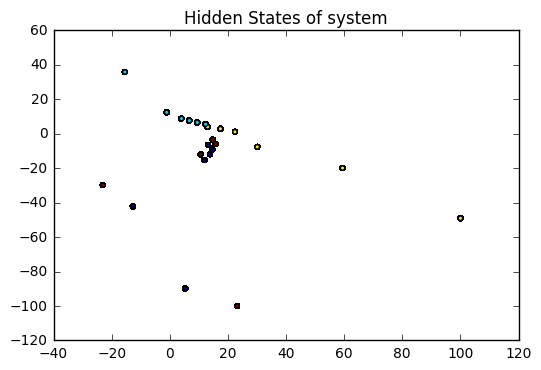

In [7]:
config = get_config()
with tf.Graph().as_default():
    initializer = tf.random_uniform_initializer(-config.init_scale,
                                               config.init_scale)
    with tf.name_scope("Train"):
        train_input = DNA_input(config, raw_data, "TrainInput")
        with tf.variable_scope("Model", reuse=None, initializer=initializer):
            m = DNA_seq_model(is_training=True, config=config, input_=train_input)
    sv = tf.train.Supervisor(logdir='test2')
    with sv.managed_session() as session:
        for i in range(config.max_max_epochs):
            lr_decay = config.lr_decay ** max(i+1-config.max_epochs, 0.0)
            m.assign_lr(session, config.learning_rate * lr_decay)
#             print(session.run(m.recovered_state[0]).shape)
            print("Epoch: %d Learning rate: %.3f" % (i + 1, session.run(m.lr)))
            train_perplexity = run_epoch(session, m, eval_op=m.train_op,
                                         verbose=True)
            print("Epoch: %d Train Perplexity: %.3f" % (i + 1, train_perplexity))
        x,y,l = visualize_states(session, m, config)
        
            

In [11]:
len(l)

10000

In [9]:
sv = tf.train.Supervisor(logdir='test2')
with sv.managed_session() as session:
    a,b,c,d = session.run([x1,x2,x3,x4])
#     b = x2.eval(session=session)
#     c = x3.eval(session=session)
    print(a)
    print(b)
    print(c)
    print(d)

NameError: name 'x1' is not defined

In [ ]:
a=(1,2)
b=(a[0]*1)